# S&P 500 Price Prediction Model Evaluation

This notebook allows you to load trained models and evaluate their performance on test data and custom sequences.

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats

# Import project modules
import sys
sys.path.append('./')
from scripts.data_loader import load_data
from scripts.preprocess import prepare_data, create_sequences
from scripts.models_pytorch import LSTMModel, CNNModel
from scripts.config import FEATURES, TARGET_COL, SEQUENCE_LENGTH, PREDICTION_HORIZON

## 1. Load Data and Models

In [2]:
df = load_data()
df_original_for_simulation = df.copy() # Create a copy for simulation and other raw data needs

# Preprocess data (will return train, validation, test splits and scalers)
# Unpack all values, including y_test_orig for raw targets
X_train, X_val, X_test, y_train, y_val, y_test, \
y_train_orig, y_val_orig, y_test_orig, scalers = prepare_data(df, denoise_features=True) # Assuming denoise_features=True is the default used for training

# Convert test data to tensors
X_test_tensor = torch.FloatTensor(X_test)
# y_test_tensor is the scaled, denoised target, used if you were to pass targets to a model.eval() loop here
# y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1) 

# Load models
lstm_model = LSTMModel(input_size=len(FEATURES))
lstm_model.load_state_dict(torch.load('models_saved/lstm_model.pt'))
lstm_model.eval()

# Correct CNNModel instantiation
cnn_model = CNNModel(input_channels=len(FEATURES), sequence_length=SEQUENCE_LENGTH)
cnn_model.load_state_dict(torch.load('models_saved/noisecnn_model.pt'))
cnn_model.eval()

Données chargées avec succès: 6289 lignes et 6 colonnes
Aperçu des données:
        Price        Close         High          Low         Open      Volume
0  03/01/2000  1455.219971  1478.000000  1438.359985  1469.250000   931800000
1  04/01/2000  1399.420044  1455.219971  1397.430054  1455.219971  1009000000
2  05/01/2000  1402.109985  1413.270020  1377.680054  1399.420044  1085500000
3  06/01/2000  1403.449951  1411.900024  1392.099976  1402.109985  1092300000
4  07/01/2000  1441.469971  1441.469971  1400.729980  1403.449951  1225200000
Aucune valeur manquante détectée.
Applying wavelet denoising...


c:\Users\Cameron\OneDrive\Bureau\Ecole\Deep\Projet\predictsp500 - Copy\scripts\preprocess.py:94: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_for_processing[col] = denoised_col.reindex(df_for_processing.index).fillna(method='bfill').fillna(method='ffill')


Taille des ensembles - Train: (5386, 60, 4), Validation: (406, 60, 4), Test: (436, 60, 4)


C:\Users\Cameron\AppData\Local\Temp\ipykernel_39944\4142474945.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm_model.load_state_dict(torch.load('models_saved/lstm_

CNNModel(
  (layers): ModuleList(
    (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=640, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## 2. Make Predictions on Test Data

In [3]:
# ...existing code...
# Function to make predictions and inverse transform them
def make_predictions(model, X):
    model.eval()
    with torch.no_grad():
        predictions = model(X).numpy()
    
    # Inverse transform predictions. Scaler for TARGET_COL was fit on denoised data.
    # So, predictions_inversed are estimates of the denoised target, on original scale.
    predictions_inversed = scalers[TARGET_COL].inverse_transform(predictions)
    return predictions_inversed.flatten()

# Get predictions
lstm_preds = make_predictions(lstm_model, X_test_tensor)
cnn_preds = make_predictions(cnn_model, X_test_tensor)

# y_test is the scaled, denoised target from prepare_data
# y_test_denoised_unscaled is the unscaled version of the denoised target
y_test_denoised_unscaled = scalers[TARGET_COL].inverse_transform(y_test.reshape(-1, 1)).flatten()

# y_test_orig is the raw, unscaled target from prepare_data
y_test_raw_unscaled =  y_test_orig.flatten()

## 3. Visualize Predictions vs Actual

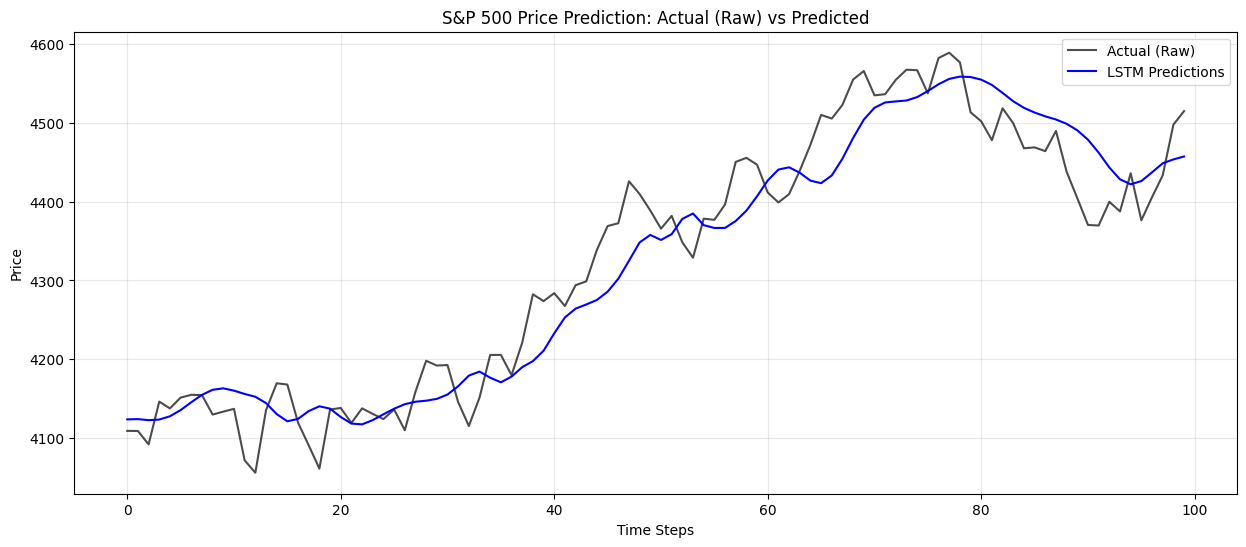

In [4]:
# Plot a subset of the test data (e.g., 100 data points) for better visualization
sample_size = 100
plt.figure(figsize=(15, 6))
# Compare against raw (original) actual prices
plt.plot(y_test_raw_unscaled[:sample_size], label='Actual (Raw)', color='black', alpha=0.7)
plt.plot(lstm_preds[:sample_size], label='LSTM Predictions', color='blue')
#plt.plot(cnn_preds[:sample_size], label='CNN Predictions', color='red')
# Optionally, plot denoised actuals for reference:
# plt.plot(y_test_denoised_unscaled[:sample_size], label='Actual (Denoised)', color='green', linestyle=':', alpha=0.5)
plt.title('S&P 500 Price Prediction: Actual (Raw) vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

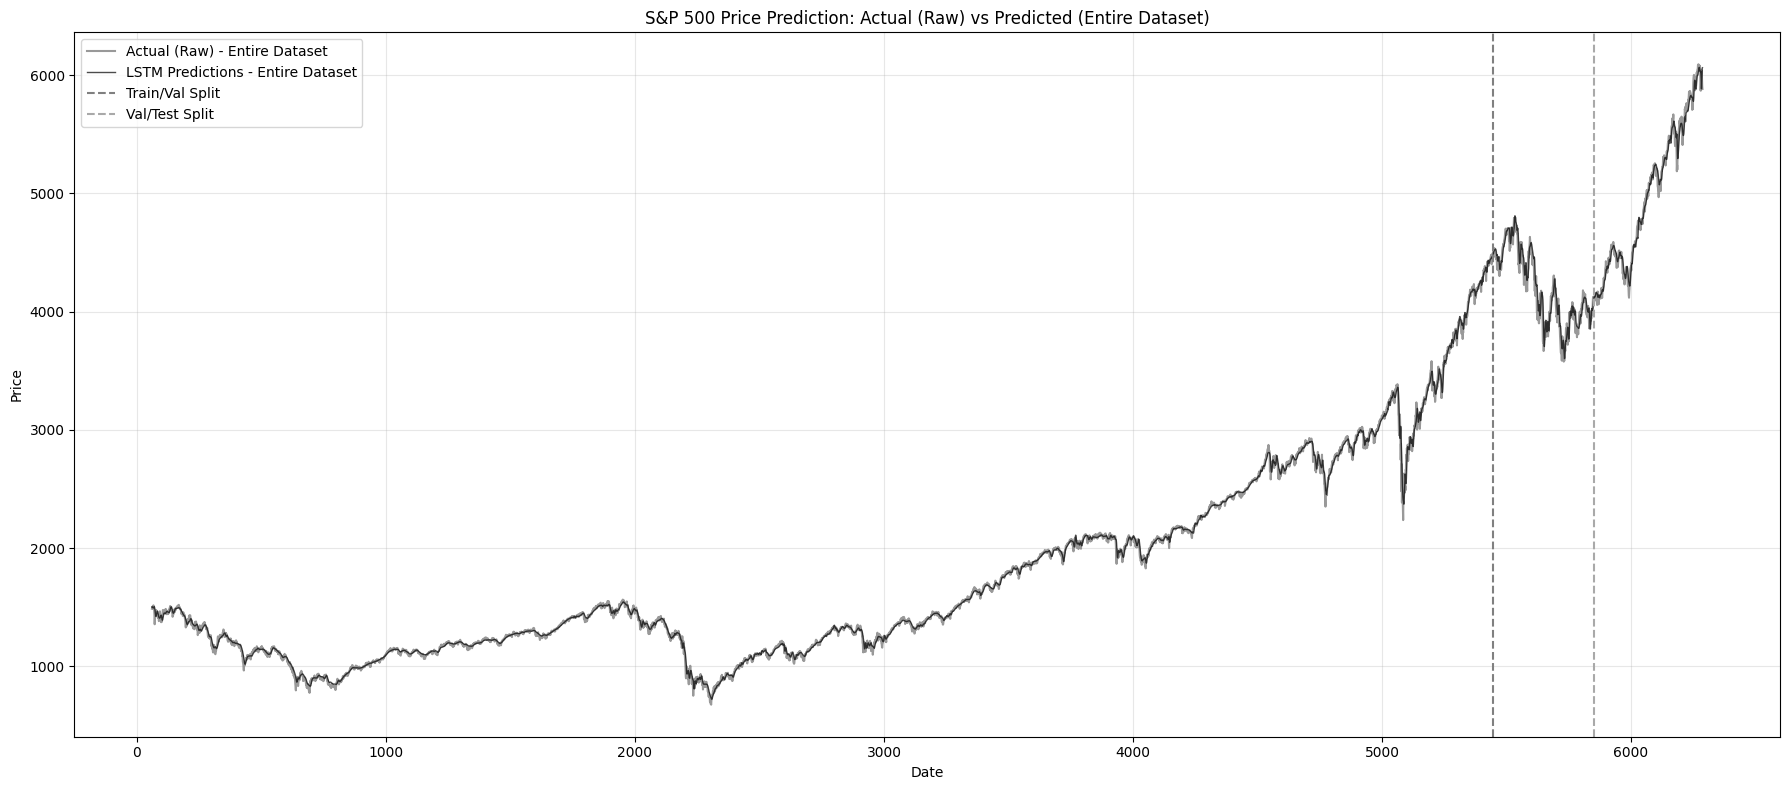

In [5]:

# --- Predictions for Train and Validation Sets ---
# Convert train and validation features to tensors
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)

# Make predictions on train set
# The make_predictions function is defined in cell be2dcc4b
lstm_train_preds = make_predictions(lstm_model, X_train_tensor)
cnn_train_preds = make_predictions(cnn_model, X_train_tensor)

# Make predictions on validation set
lstm_val_preds = make_predictions(lstm_model, X_val_tensor)
cnn_val_preds = make_predictions(cnn_model, X_val_tensor)

# --- Unscaled Actuals for Train and Validation Sets ---
# y_train_orig, y_val_orig, y_test_orig are available from cell d3635131
# y_test_raw_unscaled is already defined in cell be2dcc4b
y_train_raw_unscaled = y_train_orig.flatten()
y_val_raw_unscaled = y_val_orig.flatten()

# --- Concatenate all actuals and predictions ---
# Actuals
all_actuals = np.concatenate([y_train_raw_unscaled, y_val_raw_unscaled, y_test_raw_unscaled])

# LSTM Predictions
all_lstm_preds = np.concatenate([lstm_train_preds, lstm_val_preds, lstm_preds])

# CNN Predictions
all_cnn_preds = np.concatenate([cnn_train_preds, cnn_val_preds, cnn_preds])

# --- Dates for Plotting ---
# The y_orig arrays (and thus predictions) correspond to target values after sequence creation.
# Their combined length is len(all_actuals).
# These targets start from index: SEQUENCE_LENGTH + PREDICTION_HORIZON - 1 in the original dataframe.
# From config, PREDICTION_HORIZON is 1, so it starts from SEQUENCE_LENGTH.
start_index_for_targets = SEQUENCE_LENGTH 
num_total_targets = len(all_actuals)

# Use df_original_for_simulation for dates to ensure we have the original, unmodified index
plot_dates = df_original_for_simulation.index[start_index_for_targets : start_index_for_targets + num_total_targets]

# --- Plotting ---
plt.figure(figsize=(18, 8)) # Adjusted figsize for better readability of the whole dataset
plt.plot(plot_dates, all_actuals, label='Actual (Raw) - Entire Dataset', color='grey', alpha=0.8, linewidth=1.5)
plt.plot(plot_dates, all_lstm_preds, label='LSTM Predictions - Entire Dataset', color='black', alpha=0.7, linewidth=1)
#plt.plot(plot_dates, all_cnn_preds, label='CNN Predictions - Entire Dataset', color='navy', alpha=0.7, linewidth=1)

# Add vertical lines to distinguish train, validation, and test sets
len_train_y = len(y_train_raw_unscaled)
len_val_y = len(y_val_raw_unscaled)

# Date for the end of training data / start of validation data
if len_train_y > 0 and len_train_y < len(plot_dates):
    val_start_date = plot_dates[len_train_y]
    plt.axvline(x=val_start_date, color='gray', linestyle='--', label='Train/Val Split')

# Date for the end of validation data / start of test data
if len_val_y > 0 and (len_train_y + len_val_y) < len(plot_dates):
    test_start_date = plot_dates[len_train_y + len_val_y]
    plt.axvline(x=test_start_date, color='darkgray', linestyle='--', label='Val/Test Split')

plt.title('S&P 500 Price Prediction: Actual (Raw) vs Predicted (Entire Dataset)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout() # Adjust layout to make room for legend and labels
plt.show()


## 4. Error Analysis

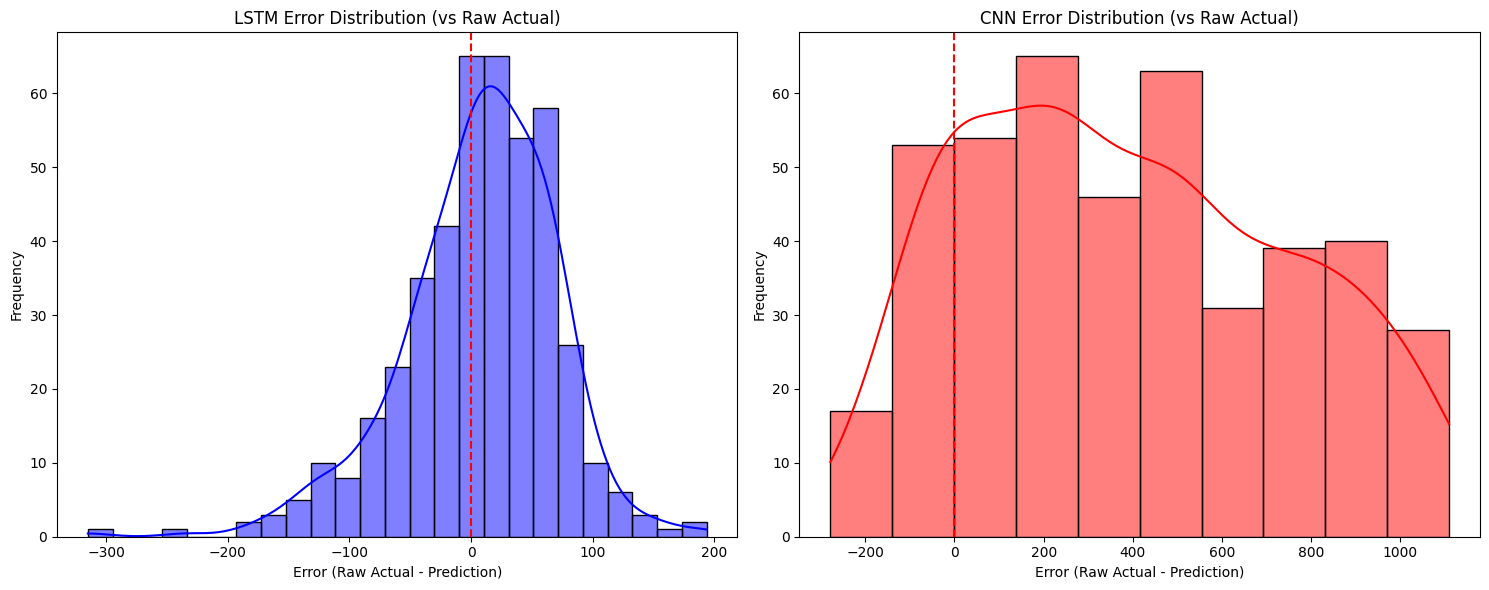

LSTM Error Statistics (vs Raw Actual):
Mean Error: 6.94
Std Dev: 63.14
Min Error: -315.07
Max Error: 193.54

CNN Error Statistics (vs Raw Actual):
Mean Error: 389.25
Std Dev: 354.91
Min Error: -278.51
Max Error: 1109.59


In [6]:

# Calculate errors against raw (original) actual prices
lstm_errors = y_test_raw_unscaled - lstm_preds
cnn_errors = y_test_raw_unscaled - cnn_preds

# Error distribution
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.histplot(lstm_errors, kde=True, color='blue')
plt.axvline(x=0, color='red', linestyle='--')
plt.title('LSTM Error Distribution (vs Raw Actual)')
plt.xlabel('Error (Raw Actual - Prediction)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(cnn_errors, kde=True, color='red')
plt.axvline(x=0, color='red', linestyle='--')
plt.title('CNN Error Distribution (vs Raw Actual)')
plt.xlabel('Error (Raw Actual - Prediction)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print error statistics (errors are now vs raw actual)
print("LSTM Error Statistics (vs Raw Actual):")
print(f"Mean Error: {np.mean(lstm_errors):.2f}")
print(f"Std Dev: {np.std(lstm_errors):.2f}")
print(f"Min Error: {np.min(lstm_errors):.2f}")
print(f"Max Error: {np.max(lstm_errors):.2f}")
print("\nCNN Error Statistics (vs Raw Actual):")
print(f"Mean Error: {np.mean(cnn_errors):.2f}")
print(f"Std Dev: {np.std(cnn_errors):.2f}")
print(f"Min Error: {np.min(cnn_errors):.2f}")
print(f"Max Error: {np.max(cnn_errors):.2f}")


## 5. Residual Analysis

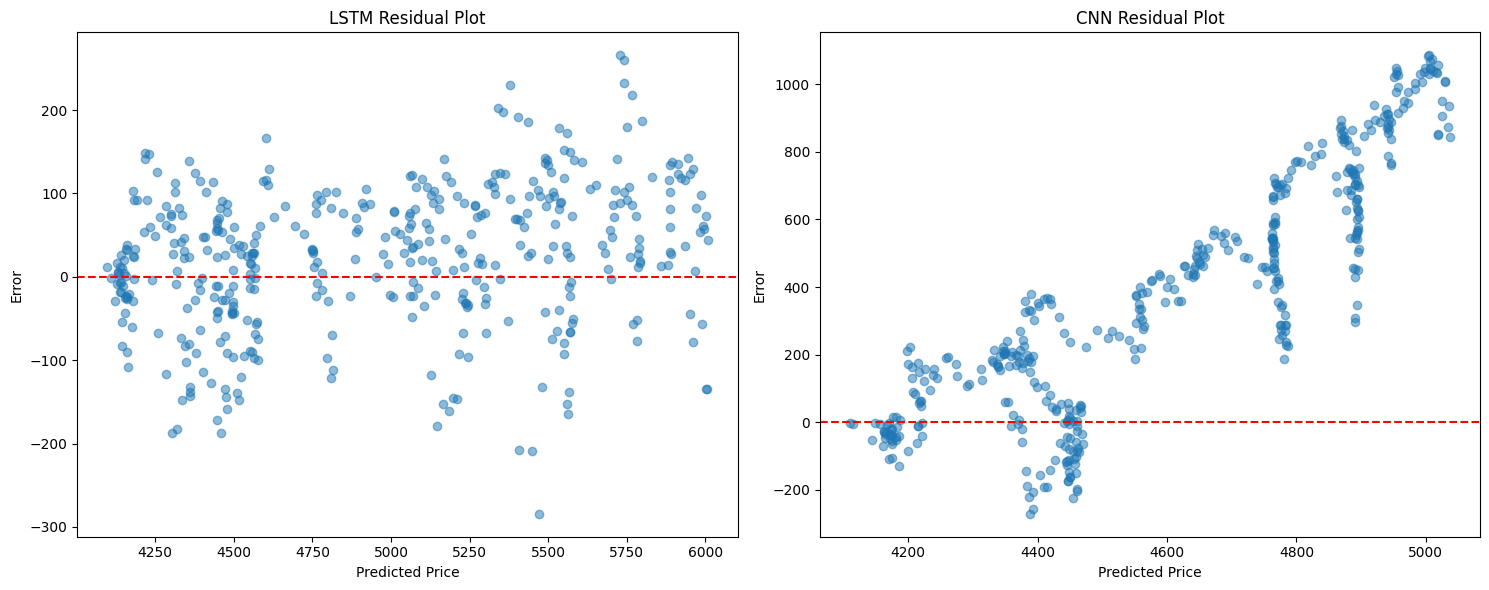

In [46]:
# Residual plots (errors vs predicted values)
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(lstm_preds, lstm_errors, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('LSTM Residual Plot')
plt.xlabel('Predicted Price')
plt.ylabel('Error')

plt.subplot(1, 2, 2)
plt.scatter(cnn_preds, cnn_errors, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('CNN Residual Plot')
plt.xlabel('Predicted Price')
plt.ylabel('Error')

plt.tight_layout()
plt.show()

# Check for heteroscedasticity - if errors increase with predicted values
# If there's a pattern in residuals, the model may need improvement

## 6. Error by Price Range

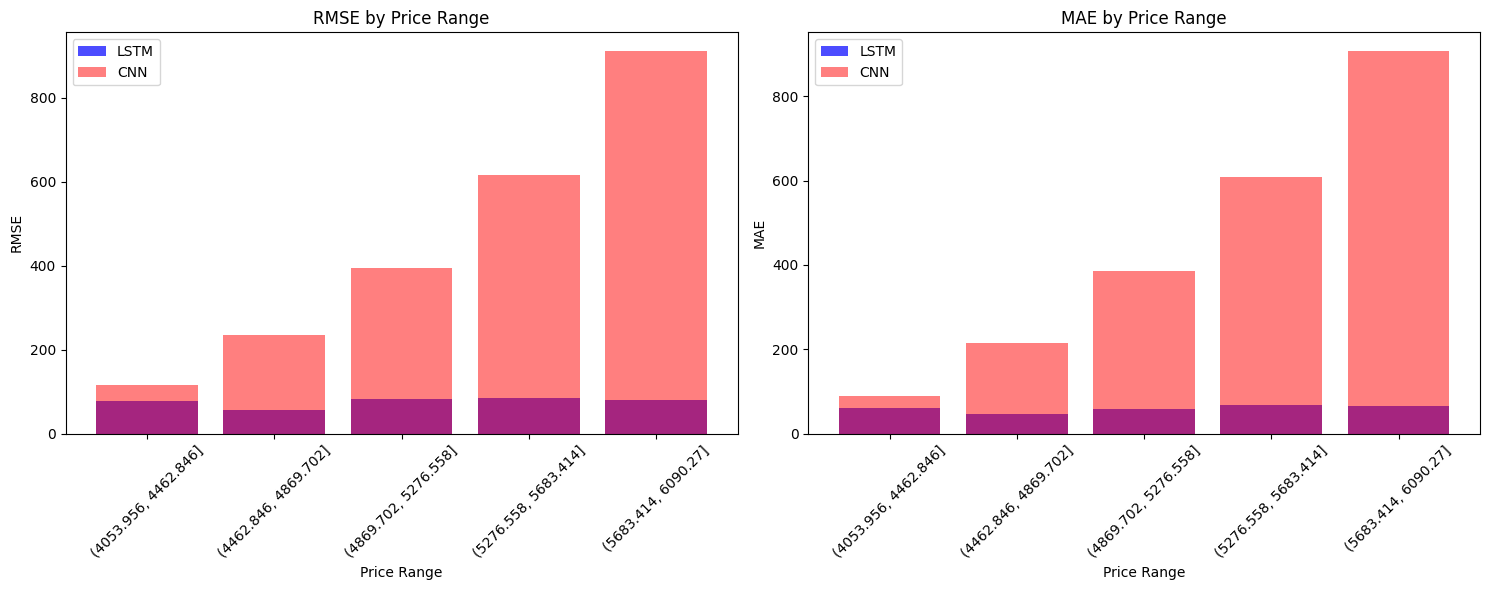

In [15]:

# Create bins for price ranges based on raw (original) actual prices
price_bins = pd.cut(y_test_raw_unscaled, bins=5)
price_ranges = sorted(price_bins.unique())

# Calculate metrics for each price range (comparing predictions to raw actuals)
lstm_rmse_by_range = []
cnn_rmse_by_range = []
lstm_mae_by_range = []
cnn_mae_by_range = []

for price_range in price_ranges:
    mask = (price_bins == price_range)
    
    # LSTM metrics vs raw actual
    lstm_rmse = np.sqrt(mean_squared_error(y_test_raw_unscaled[mask], lstm_preds[mask]))
    lstm_mae = mean_absolute_error(y_test_raw_unscaled[mask], lstm_preds[mask])
    lstm_rmse_by_range.append(lstm_rmse)
    lstm_mae_by_range.append(lstm_mae)
    
    # CNN metrics vs raw actual
    cnn_rmse = np.sqrt(mean_squared_error(y_test_raw_unscaled[mask], cnn_preds[mask]))
    cnn_mae = mean_absolute_error(y_test_raw_unscaled[mask], cnn_preds[mask])
    cnn_rmse_by_range.append(cnn_rmse)
    cnn_mae_by_range.append(cnn_mae)



# Plot RMSE by price range
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.bar([str(r) for r in price_ranges], lstm_rmse_by_range, color='blue', alpha=0.7, label='LSTM')
plt.bar([str(r) for r in price_ranges], cnn_rmse_by_range, color='red', alpha=0.5, label='CNN')
plt.title('RMSE by Price Range')
plt.xlabel('Price Range')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.legend()

plt.subplot(1, 2, 2)
plt.bar([str(r) for r in price_ranges], lstm_mae_by_range, color='blue', alpha=0.7, label='LSTM')
plt.bar([str(r) for r in price_ranges], cnn_mae_by_range, color='red', alpha=0.5, label='CNN')
plt.title('MAE by Price Range')
plt.xlabel('Price Range')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

## 7. Performance by Market Volatility

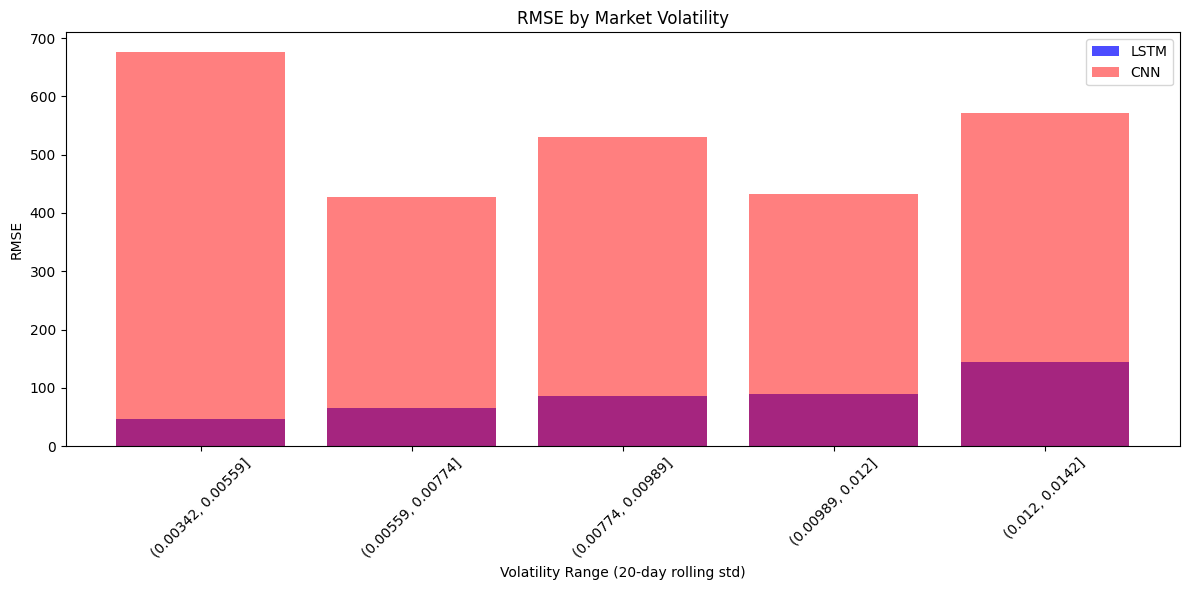

In [17]:

test_dates = df.index[-len(y_test_raw_unscaled):] 
test_volatility = volatility.reindex(test_dates, method='ffill').fillna(0) # fillna for safety

# Create volatility bins
volatility_bins = pd.cut(test_volatility, bins=5)
volatility_ranges = sorted(volatility_bins.unique())

# Calculate metrics for each volatility range (comparing predictions to raw actuals)
lstm_rmse_by_vol = []
cnn_rmse_by_vol = []

for vol_range in volatility_ranges:
    mask = (volatility_bins == vol_range)
    if sum(mask) > 0:  # Ensure there are data points in this bin
        lstm_rmse = np.sqrt(mean_squared_error(y_test_raw_unscaled[mask], lstm_preds[mask]))
        cnn_rmse = np.sqrt(mean_squared_error(y_test_raw_unscaled[mask], cnn_preds[mask]))
        
        lstm_rmse_by_vol.append(lstm_rmse)
        cnn_rmse_by_vol.append(cnn_rmse)
    else:
        lstm_rmse_by_vol.append(np.nan) # Use NaN if no data, to avoid issues with bar plot if all are 0
        cnn_rmse_by_vol.append(np.nan)



# Plot RMSE by volatility
plt.figure(figsize=(12, 6))
plt.bar([str(r) for r in volatility_ranges], lstm_rmse_by_vol, color='blue', alpha=0.7, label='LSTM')
plt.bar([str(r) for r in volatility_ranges], cnn_rmse_by_vol, color='red', alpha=0.5, label='CNN')
plt.title('RMSE by Market Volatility')
plt.xlabel('Volatility Range (20-day rolling std)')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## 8. Prediction Confidence Intervals

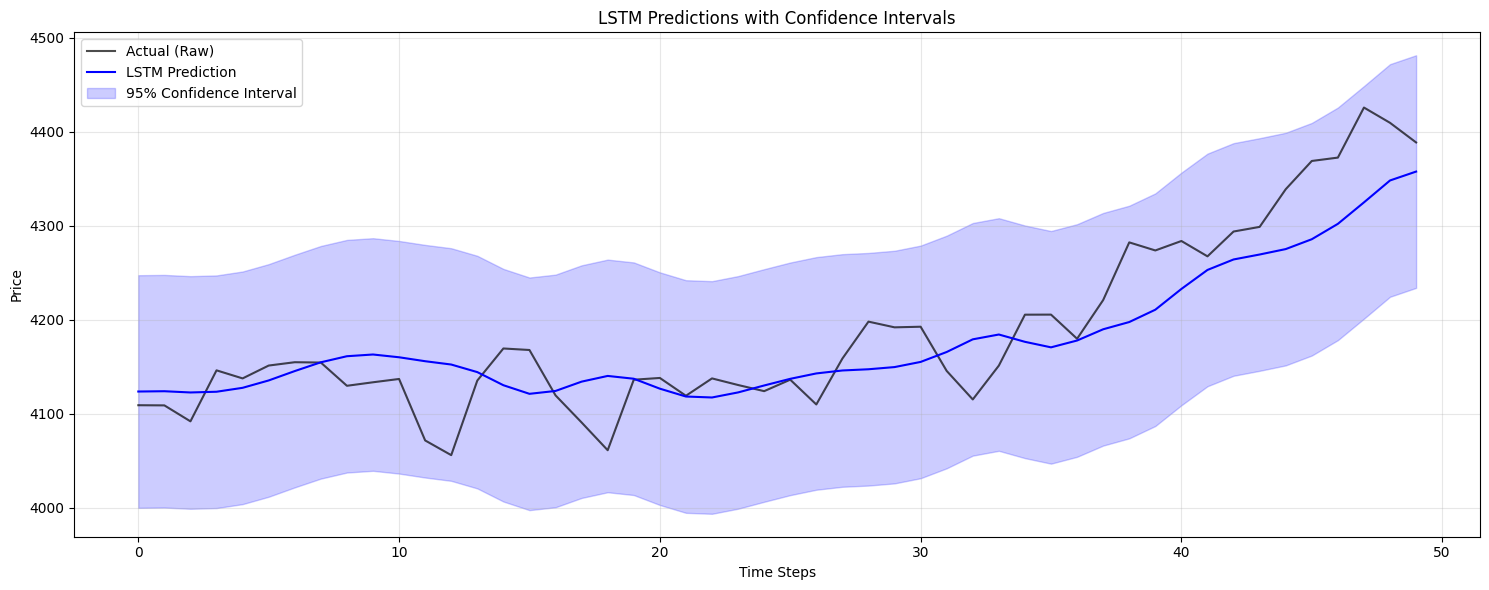

In [7]:
# ...existing code...
# Calculate confidence intervals for LSTM predictions
# lstm_errors are now calculated against raw actuals
lstm_error_std = np.std(lstm_errors) 
confidence_level = 0.95
z_score = stats.norm.ppf((1 + confidence_level) / 2)  # For 95% confidence

# Plot predictions with confidence intervals for a subset of data
sample_size = 50
start_idx = 0 # You can change this to view different parts of the test set

plt.figure(figsize=(15, 6))

# Actual raw prices
plt.plot(range(start_idx, start_idx + sample_size), 
         y_test_raw_unscaled[start_idx:start_idx + sample_size], 
         'k-', label='Actual (Raw)', alpha=0.7)


# LSTM predictions
plt.plot(range(start_idx, start_idx + sample_size), 
         lstm_preds[start_idx:start_idx + sample_size], 
         'b-', label='LSTM Prediction')

# Confidence intervals
upper_bound = lstm_preds[start_idx:start_idx + sample_size] + z_score * lstm_error_std
lower_bound = lstm_preds[start_idx:start_idx + sample_size] - z_score * lstm_error_std

plt.fill_between(range(start_idx, start_idx + sample_size), 
                 lower_bound, upper_bound, 
                 color='blue', alpha=0.2, label=f'{confidence_level*100:.0f}% Confidence Interval')

plt.title('LSTM Predictions with Confidence Intervals')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Test Custom Sequence

In [27]:
def predict_next_price(model, input_sequence, features_list=FEATURES):
    """
    Predict the next price given a sequence of input data.
    
    Args:
        model: Trained model
        input_sequence: DataFrame with columns matching FEATURES
        features_list: List of feature names to use
        
    Returns:
        Predicted price
    """
    # Ensure sequence has the correct length
    if len(input_sequence) < SEQUENCE_LENGTH:
        raise ValueError(f"Input sequence must have at least {SEQUENCE_LENGTH} time steps")
    
    # Use the most recent SEQUENCE_LENGTH time steps
    if len(input_sequence) > SEQUENCE_LENGTH:
        input_sequence = input_sequence.iloc[-SEQUENCE_LENGTH:]
    
    # Scale input features using the same scalers used during training
    scaled_input = pd.DataFrame(index=input_sequence.index)
    for feature in features_list:
        if feature in scalers:
            scaled_input[feature] = scalers[feature].transform(input_sequence[[feature]])
        else:
            raise ValueError(f"No scaler found for feature: {feature}")
    
    # Convert to tensor
    input_tensor = torch.FloatTensor(scaled_input[features_list].values).unsqueeze(0)  # Add batch dimension
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        prediction = model(input_tensor).item()
    
    # Inverse transform prediction
    predicted_price = scalers[TARGET_COL].inverse_transform(np.array([[prediction]]))[0][0]
    
    return predicted_price

# Let's test with a random sequence from the original data
# Take a random start point from the original data
random_start = np.random.randint(0, len(df) - SEQUENCE_LENGTH - 10)
test_sequence = df.iloc[random_start:random_start + SEQUENCE_LENGTH]

# Get the actual next price for comparison
actual_next_price = df[TARGET_COL].iloc[random_start + SEQUENCE_LENGTH]

# Make predictions
lstm_next_price = predict_next_price(lstm_model, test_sequence, FEATURES)
cnn_next_price = predict_next_price(cnn_model, test_sequence, FEATURES)

print(f"Sequence period: {test_sequence.index[0]} to {test_sequence.index[-1]}")
print(f"Actual next price: ${actual_next_price:.2f}")
print(f"LSTM predicted price: ${lstm_next_price:.2f}")
print(f"CNN predicted price: ${cnn_next_price:.2f}")

print(f"LSTM error: ${actual_next_price - lstm_next_price:.2f} ({(actual_next_price - lstm_next_price) / actual_next_price * 100:.2f}%)")
print(f"CNN error: ${actual_next_price - cnn_next_price:.2f} ({(actual_next_price - cnn_next_price) / actual_next_price * 100:.2f}%)")

Sequence period: 4986 to 5045
Actual next price: $3295.47
LSTM predicted price: $3320.02
CNN predicted price: $3251.10
LSTM error: $-24.55 (-0.74%)
CNN error: $44.37 (1.35%)


## 10. Multi-Step Predictions

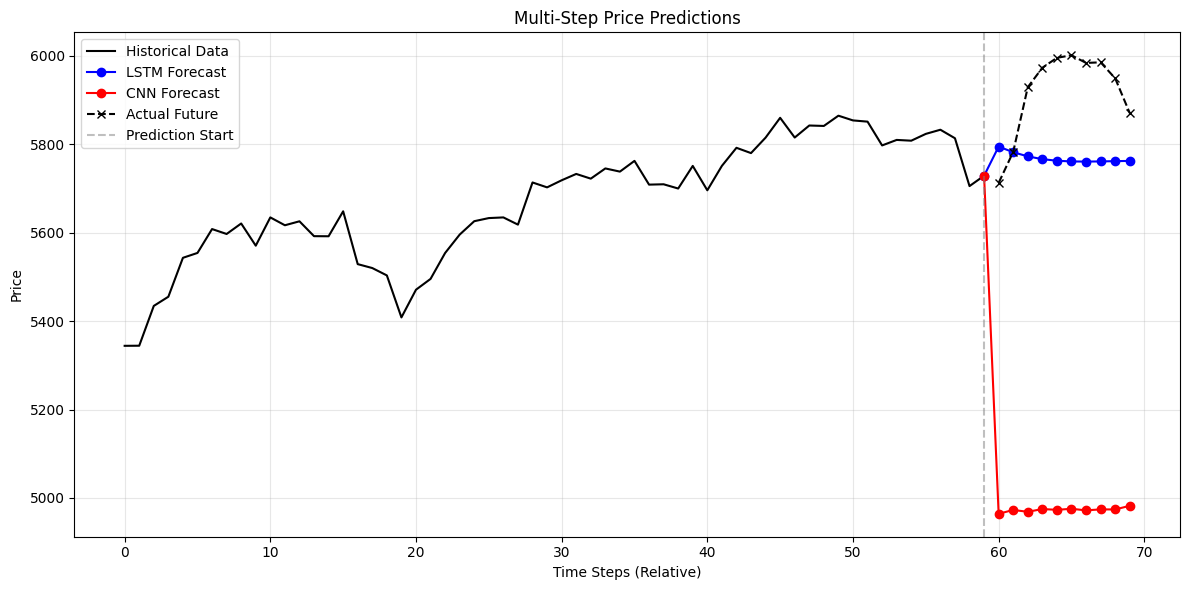

LSTM Multi-step RMSE: 182.37
CNN Multi-step RMSE: 949.65


In [79]:
# ...existing code...
def predict_multi_step(model, initial_sequence_df: pd.DataFrame, steps: int = 5, features_list: list = FEATURES, target_col: str = TARGET_COL):
    """
    Make multi-step predictions by feeding predictions back as inputs.
    
    Args:
        model: Trained model.
        initial_sequence_df: DataFrame with the initial sequence of data.
                             It should contain all columns necessary for prediction.
        steps: Number of steps to predict forward.
        features_list: List of feature names the model uses (passed to predict_next_price).
        target_col: Name of the target column to be predicted.
        
    Returns:
        List of predicted prices (unscaled).
    """
    current_sequence = initial_sequence_df.copy()
    predictions_list = []
    
    last_known_index = current_sequence.index[-1]

    for _ in range(steps):
        # Predict the next price (predict_next_price handles scaling and returns unscaled value)
        predicted_target_value = predict_next_price(model, current_sequence, features_list)
        predictions_list.append(predicted_target_value)
        
        # Determine the next index for the new row
        if isinstance(last_known_index, pd.Timestamp):
            # Assumes daily data; for other frequencies, this might need adjustment
            # e.g., using pandas.tseries.offsets for business days: next_index = last_known_index + pd.offsets.BDay(1)
            next_index = last_known_index + pd.Timedelta(days=1)
        elif np.issubdtype(type(last_known_index), np.integer):
            next_index = last_known_index + 1
        else:
            # Attempt a generic increment for other numeric-like indices
            try:
                next_index = last_known_index + 1
            except TypeError:
                raise TypeError(
                    f"Unsupported index type '{type(last_known_index)}' for simple incrementing. "
                    "Customize index generation in predict_multi_step if needed."
                )

        # Prepare data for the new row
        # Start by copying the last known values for all columns
        new_row_data = current_sequence.iloc[-1].copy().to_dict()
        # Update the target column with the predicted value
        new_row_data[target_col] = predicted_target_value
        
        # Create the new row as a DataFrame
        new_row_df = pd.DataFrame(new_row_data, index=[next_index])
        
        # Ensure the new_row_df has the same columns in the same order as current_sequence
        # This is important for pd.concat to behave as expected.
        new_row_df = new_row_df[current_sequence.columns] 

        # Append the new row and remove the oldest row from the sequence
        current_sequence = pd.concat([current_sequence.iloc[1:], new_row_df])
        last_known_index = next_index # Update for the next iteration
    
    return predictions_list

# Choose a starting point
start_idx = len(df) - 100  # Use one of the last sequences
# initial_sequence should be a DataFrame. Using df.iloc will provide this.
# It should contain all columns that predict_next_price might need from features_list.
initial_sequence = df.iloc[start_idx:start_idx + SEQUENCE_LENGTH]

# Make multi-step predictions (10 days forward)
steps_forward = 10
# Pass features_list and target_col explicitly for clarity, though they have defaults
lstm_future_preds = predict_multi_step(lstm_model, initial_sequence, steps=steps_forward, features_list=FEATURES, target_col=TARGET_COL)
cnn_future_preds = predict_multi_step(cnn_model, initial_sequence, steps=steps_forward, features_list=FEATURES, target_col=TARGET_COL)

# If we have actual data for these future dates, compare the predictions
actual_future = None
if start_idx + SEQUENCE_LENGTH + steps_forward <= len(df):
    actual_future = df[TARGET_COL].iloc[start_idx + SEQUENCE_LENGTH:start_idx + SEQUENCE_LENGTH + steps_forward].values

# Plot the predictions
plt.figure(figsize=(12, 6))

# Plot historical data
historical_data = df[TARGET_COL].iloc[start_idx:start_idx + SEQUENCE_LENGTH].values
plt.plot(range(SEQUENCE_LENGTH), historical_data, 'k-', label='Historical Data')

# Plot predictions
# The x-axis range and data list length must match.
# range has (SEQUENCE_LENGTH + steps_forward) - (SEQUENCE_LENGTH - 1) = steps_forward + 1 points.
# data list [historical_data[-1]] + *_future_preds has 1 + steps_forward points.
plt.plot(range(SEQUENCE_LENGTH - 1, SEQUENCE_LENGTH + steps_forward), 
         [historical_data[-1]] + lstm_future_preds, 'b-', marker='o', label='LSTM Forecast')
plt.plot(range(SEQUENCE_LENGTH - 1, SEQUENCE_LENGTH + steps_forward), 
         [historical_data[-1]] + cnn_future_preds, 'r-', marker='o', label='CNN Forecast')

# Plot actual future data if available
# The x-axis range and data list length must match.
# range has (SEQUENCE_LENGTH + steps_forward) - SEQUENCE_LENGTH = steps_forward points.
# actual_future has steps_forward points.
if actual_future is not None:
    plt.plot(range(SEQUENCE_LENGTH, SEQUENCE_LENGTH + steps_forward), 
             actual_future, 'k--', marker='x', label='Actual Future')

plt.title('Multi-Step Price Predictions')
plt.xlabel('Time Steps (Relative)')
plt.ylabel('Price')
plt.axvline(x=SEQUENCE_LENGTH - 1, color='gray', linestyle='--', alpha=0.5, label='Prediction Start')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate errors if actual data is available
if actual_future is not None:
    lstm_multi_rmse = np.sqrt(mean_squared_error(actual_future, lstm_future_preds))
    cnn_multi_rmse = np.sqrt(mean_squared_error(actual_future, cnn_future_preds))
    print(f"LSTM Multi-step RMSE: {lstm_multi_rmse:.2f}")
    print(f"CNN Multi-step RMSE: {cnn_multi_rmse:.2f}")
# ...existing code...

## 11. Areas for Model Improvement

In [ ]:
# Based on the analysis, here are potential areas for improvement:

improvement_areas = [
    "Feature Engineering:",
    "- Add technical indicators (e.g., moving averages, RSI, MACD)",
    "- Include external factors (e.g., interest rates, VIX index)",
    "- Create features capturing market sentiment",
    "\nModel Architecture:",
    "- Try deeper networks with more layers",
    "- Experiment with different LSTM variants (GRU, BiLSTM)",
    "- Implement attention mechanisms",
    "- Explore transformer-based architectures",
    "\nTraining Process:",
    "- Implement learning rate scheduling",
    "- Try different optimizers (RMSprop, AdamW)",
    "- Use more sophisticated regularization techniques",
    "- Experiment with different loss functions (Huber loss, quantile loss)",
    "\nEnsemble Methods:",
    "- Combine different model types (LSTM + CNN)",
    "- Create ensembles with different prediction horizons",
    "- Use stacking or blending techniques"
]

for area in improvement_areas:
    print(area)

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
from tqdm.notebook import tqdm # Import tqdm for progress bar


def trading_simulator(model, df, initial_capital=1000, features_list=None, risk_factor=1.0, confidence_threshold=0.0):
    """
    Simulates trading based on model predictions. Optimized for speed.
    
    Args:
        model: Trained model.
        df: Full DataFrame of price data, must have a DatetimeIndex. This should be df_test_period.
        initial_capital: Starting capital amount.
        features_list: List of features for prediction. Defaults to global FEATURES if None.
        risk_factor: Multiplier for position sizing.
        confidence_threshold: Minimum absolute predicted percentage change to make a trade.
        
    Returns:
        dict with performance metrics and trading history.
    """
    if features_list is None:
        from scripts.config import FEATURES
        features_list = FEATURES
    from scripts.config import TARGET_COL, SEQUENCE_LENGTH

    # --- Start: Added Pre-flight Checks ---
    actual_df_columns = df.columns
    missing_features_in_df = [f for f in features_list if f not in actual_df_columns]
    if missing_features_in_df:
        raise ValueError(
            f"Input DataFrame to trading_simulator (df_test_period) is missing features: {missing_features_in_df}. "
            f"These are expected based on features_list (from config.FEATURES). "
            f"DataFrame columns: {list(actual_df_columns)}. "
            f"Ensure df_test_period has all columns consistent with FEATURES and the 'df' used in 'prepare_data'."
        )
    if TARGET_COL not in actual_df_columns:
        raise ValueError(
            f"Input DataFrame to trading_simulator (df_test_period) is missing TARGET_COL: '{TARGET_COL}'. "
            f"DataFrame columns: {list(actual_df_columns)}. "
            f"Ensure df_test_period has the TARGET_COL."
        )
    # --- End: Added Pre-flight Checks ---

    capital = initial_capital
    
    target_prices_arr = df[TARGET_COL].values
    df_indices = df.index 

    num_simulation_steps = len(df) - SEQUENCE_LENGTH - 1

    initial_log_date = None
    if SEQUENCE_LENGTH > 0 and (SEQUENCE_LENGTH - 1) < len(df_indices):
        initial_log_date = df_indices[SEQUENCE_LENGTH - 1]
    
    if num_simulation_steps < 0:
        out_dates = [initial_log_date] if initial_log_date is not None else []
        out_capital = [initial_capital] if initial_log_date is not None else []
        return {
            'initial_capital': initial_capital, 'final_capital': initial_capital,
            'total_return': 0.0, 'total_pnl': 0.0, 'mean_daily_return': 0.0,
            'sharpe_ratio': 0.0, 'max_drawdown': 0.0,
            'daily_capital': out_capital, 'dates': out_dates, 'positions': []
        }

    sim_positions = [None] * num_simulation_steps 
    daily_capital_log = [0.0] * (num_simulation_steps + 1)
    daily_capital_log[0] = initial_capital
    
    trade_decision_dates_log = [None] * num_simulation_steps
    sim_daily_returns = [0.0] * num_simulation_steps

    for sim_step_idx in tqdm(range(num_simulation_steps), desc="Trading Simulation Progress", leave=False):
        current_df_idx = SEQUENCE_LENGTH + sim_step_idx
        current_date = df_indices[current_df_idx]
        current_price = target_prices_arr[current_df_idx]
        
        seq_start_idx = current_df_idx - SEQUENCE_LENGTH
        seq_end_idx = current_df_idx
        sequence_df_slice = df.iloc[seq_start_idx:seq_end_idx]
        
        predicted_next_price = predict_next_price(model, sequence_df_slice, features_list)
        
        predicted_diff = predicted_next_price - current_price
        predicted_pct_change = predicted_diff / current_price if current_price != 0 else 0.0
        
        position_type = "NO_TRADE"
        position_size_signed = 0.0 
        pnl = 0.0

        capital_for_sizing = daily_capital_log[sim_step_idx]

        if abs(predicted_pct_change) >= confidence_threshold:
            if predicted_diff > 0:
                position_type = "LONG"
                position_size_signed = capital_for_sizing * risk_factor 
            elif predicted_diff < 0:
                position_type = "SHORT"
                position_size_signed = -capital_for_sizing * risk_factor
        
        if position_type != "NO_TRADE":
            next_actual_price = target_prices_arr[current_df_idx + 1]
            actual_pct_change = (next_actual_price - current_price) / current_price if current_price != 0 else 0.0
            pnl = position_size_signed * actual_pct_change
        
        sim_positions[sim_step_idx] = {
            'date': current_date, 'price': current_price,
            'prediction': predicted_next_price, 'type': position_type,
            'size': position_size_signed
        }
        
        capital += pnl
        daily_capital_log[sim_step_idx + 1] = capital
        trade_decision_dates_log[sim_step_idx] = current_date
        
        if capital_for_sizing != 0:
            sim_daily_returns[sim_step_idx] = pnl / capital_for_sizing
            
    mean_daily_return = np.mean(sim_daily_returns) if num_simulation_steps > 0 else 0.0
    std_daily_return = np.std(sim_daily_returns) if num_simulation_steps > 1 else 0.0 
    if num_simulation_steps == 1 and sim_daily_returns:
         std_daily_return = 0.0
    
    sharpe_ratio = (mean_daily_return / std_daily_return * np.sqrt(252)) if std_daily_return != 0 else 0.0
    total_return = (capital - initial_capital) / initial_capital if initial_capital != 0 else 0.0
    
    max_drawdown = 0.0
    if len(daily_capital_log) >= 2:
        capital_array_for_dd = np.array(daily_capital_log)
        peak = np.maximum.accumulate(capital_array_for_dd)
        safe_peak = np.where(peak == 0, 1.0, peak) 
        drawdown_values = (peak - capital_array_for_dd) / safe_peak
        drawdown_values = np.where(peak == 0, 0.0, drawdown_values)
        if len(drawdown_values) > 0:
            max_drawdown = np.max(drawdown_values)

    output_dates = []
    if initial_log_date is not None:
        output_dates.append(initial_log_date)
    
    if num_simulation_steps > 0 :
        output_dates.extend(trade_decision_dates_log)
    
    final_daily_capital_output = daily_capital_log[:len(output_dates)]

    results = {
        'initial_capital': initial_capital, 'final_capital': capital,
        'total_return': total_return, 'total_pnl': capital - initial_capital,
        'mean_daily_return': mean_daily_return, 'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'daily_capital': final_daily_capital_output,
        'dates': output_dates,
        'positions': sim_positions if num_simulation_steps > 0 else []
    }
    return results


def buy_and_hold_simulator(df, initial_capital=1000):
    """
    Simulates a buy and hold strategy.
    Args:
        df: DataFrame with price data for the simulation period.
        initial_capital: Starting capital.
    Returns:
        dict with performance metrics.
    """
    from scripts.config import TARGET_COL, SEQUENCE_LENGTH # Ensure these are accessible

    if TARGET_COL not in df.columns:
        raise ValueError(f"TARGET_COL '{TARGET_COL}' not found in DataFrame columns.")

    # If df is too short for the buy and hold strategy starting after SEQUENCE_LENGTH days
    if len(df) <= SEQUENCE_LENGTH:
        # Attempt to log initial capital at the first available date if df is not empty
        out_dates = [df.index[0]] if not df.empty else []
        out_capital = [initial_capital] if not df.empty else []
        return {
            'initial_capital': initial_capital, 'final_capital': initial_capital,
            'total_return': 0.0, 'total_pnl': 0.0, 'mean_daily_return': 0.0,
            'sharpe_ratio': 0.0, 'max_drawdown': 0.0,
            'daily_capital': out_capital, 'dates': out_dates
        }

    start_idx = SEQUENCE_LENGTH # Day index for buying
    
    start_price = df[TARGET_COL].iloc[start_idx]
    if start_price == 0: # Avoid division by zero if start price is 0
        # Log capital for the period, assuming no trade could occur
        sim_dates = list(df.index[start_idx:])
        sim_capital = [initial_capital] * len(sim_dates)
        
        # Prepend initial capital date if possible
        out_dates = []
        out_capital = []
        if SEQUENCE_LENGTH > 0 and (SEQUENCE_LENGTH - 1) < len(df.index):
            out_dates.append(df.index[SEQUENCE_LENGTH - 1])
            out_capital.append(initial_capital)
        out_dates.extend(sim_dates)
        out_capital.extend(sim_capital)

        return {
            'initial_capital': initial_capital, 'final_capital': initial_capital,
            'total_return': 0.0, 'total_pnl': 0.0, 'mean_daily_return': 0.0,
            'sharpe_ratio': 0.0, 'max_drawdown': 0.0,
            'daily_capital': out_capital, 'dates': out_dates
        }
    shares_bought = initial_capital / start_price
    
    output_daily_capital = []
    output_dates = []
    daily_returns = []

    # Log initial capital at the date before the "buy" decision takes effect
    if SEQUENCE_LENGTH > 0 and (SEQUENCE_LENGTH - 1) < len(df.index):
        output_dates.append(df.index[SEQUENCE_LENGTH - 1])
        output_daily_capital.append(initial_capital)
    
    holding_period_capital = []
    holding_period_dates = []

    for i in range(start_idx, len(df)):
        current_price = df[TARGET_COL].iloc[i]
        capital_at_i = shares_bought * current_price
        holding_period_capital.append(capital_at_i)
        holding_period_dates.append(df.index[i])

    if not holding_period_capital: # Should only happen if start_idx >= len(df)
        return { # Return initial state if no holding period occurred
            'initial_capital': initial_capital, 'final_capital': initial_capital,
            'total_return': 0.0, 'total_pnl': 0.0, 'mean_daily_return': 0.0,
            'sharpe_ratio': 0.0, 'max_drawdown': 0.0,
            'daily_capital': output_daily_capital, 'dates': output_dates
        }

    output_daily_capital.extend(holding_period_capital)
    output_dates.extend(holding_period_dates)

    # Calculate daily returns based on holding_period_capital
    if len(holding_period_capital) > 1:
        for i in range(1, len(holding_period_capital)):
            prev_cap = holding_period_capital[i-1]
            curr_cap = holding_period_capital[i]
            if prev_cap != 0:
                daily_returns.append((curr_cap - prev_cap) / prev_cap)
            else:
                daily_returns.append(0.0)
    
    final_capital = output_daily_capital[-1] if output_daily_capital else initial_capital
    total_return = (final_capital - initial_capital) / initial_capital if initial_capital != 0 else 0.0
    mean_daily_return = np.mean(daily_returns) if daily_returns else 0.0
    std_daily_return = np.std(daily_returns) if len(daily_returns) > 1 else 0.0
    sharpe_ratio = (mean_daily_return / std_daily_return * np.sqrt(252)) if std_daily_return != 0 else 0.0
    
    max_drawdown = 0.0
    if len(output_daily_capital) >= 2:
        capital_array_for_dd = np.array(output_daily_capital)
        peak = np.maximum.accumulate(capital_array_for_dd)
        safe_peak = np.where(peak == 0, 1.0, peak)
        drawdown_values = (peak - capital_array_for_dd) / safe_peak
        drawdown_values = np.where(peak == 0, 0.0, drawdown_values)
        if len(drawdown_values) > 0:
            max_drawdown = np.max(drawdown_values)
    
    results = {
        'initial_capital': initial_capital, 'final_capital': final_capital,
        'total_return': total_return, 'total_pnl': final_capital - initial_capital,
        'mean_daily_return': mean_daily_return, 'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'daily_capital': output_daily_capital, 'dates': output_dates
    }
    return results

# In the cell where simulators are run (Cell id `115a623c`):
# Define df_test_period using y_test_raw_unscaled (defined in cell `be2dcc4b`)
num_test_samples = len(y_test_raw_unscaled)
print(len(y_test_raw_unscaled))
if num_test_samples > 0:
    # Use the copied DataFrame that preserves all original columns
    if 'df_original_for_simulation' not in globals():
        raise NameError("df_original_for_simulation is not defined. Please ensure it's created after loading df.")
    df_test_period = df_original_for_simulation.iloc[-num_test_samples:].copy() 
else:
    # Create an empty DataFrame with the same columns as the original df
    if 'df_original_for_simulation' not in globals():
        raise NameError("df_original_for_simulation is not defined. Please ensure it's created after loading df.")
    df_test_period = pd.DataFrame(columns=df_original_for_simulation.columns, index=pd.DatetimeIndex([]))


# Run the trading simulators on the test period data
confidence_val = 0.001*0.7

lstm_results = trading_simulator(lstm_model, df_test_period, risk_factor=1.0, confidence_threshold=confidence_val)
cnn_results = trading_simulator(cnn_model, df_test_period, risk_factor=1.0, confidence_threshold=confidence_val)
buy_hold_results = buy_and_hold_simulator(df_test_period)

# Display results
print("===== TRADING SIMULATION RESULTS =====")
print(f"Initial Capital: ${1000:.2f}")
print("\nLSTM Model Strategy:")
print(f"Final Capital: ${lstm_results['final_capital']:.2f}")
print(f"Total Return: {lstm_results['total_return']*100:.2f}%")
print(f"Total P&L: ${lstm_results['total_pnl']:.2f}")
print(f"Sharpe Ratio: {lstm_results['sharpe_ratio']:.2f}")
print(f"Max Drawdown: {lstm_results['max_drawdown']*100:.2f}%")

print("\nCNN Model Strategy:")
print(f"Final Capital: ${cnn_results['final_capital']:.2f}")
print(f"Total Return: {cnn_results['total_return']*100:.2f}%")
print(f"Total P&L: ${cnn_results['total_pnl']:.2f}")
print(f"Sharpe Ratio: {cnn_results['sharpe_ratio']:.2f}")
print(f"Max Drawdown: {cnn_results['max_drawdown']*100:.2f}%")

print("\nBuy & Hold Strategy:")
print(f"Final Capital: ${buy_hold_results['final_capital']:.2f}")
print(f"Total Return: {buy_hold_results['total_return']*100:.2f}%")
print(f"Total P&L: ${buy_hold_results['total_pnl']:.2f}")
print(f"Sharpe Ratio: {buy_hold_results['sharpe_ratio']:.2f}")
print(f"Max Drawdown: {buy_hold_results['max_drawdown']*100:.2f}%")


436


Trading Simulation Progress:   0%|          | 0/375 [00:00<?, ?it/s]

Trading Simulation Progress:   0%|          | 0/375 [00:00<?, ?it/s]

===== TRADING SIMULATION RESULTS =====
Initial Capital: $1000.00

LSTM Model Strategy:
Final Capital: $1005.20
Total Return: 0.52%
Total P&L: $5.20
Sharpe Ratio: 0.09
Max Drawdown: 13.12%

CNN Model Strategy:
Final Capital: $771.45
Total Return: -22.86%
Total P&L: $-228.55
Sharpe Ratio: -1.36
Max Drawdown: 28.70%

Buy & Hold Strategy:
Final Capital: $1333.22
Total Return: 33.32%
Total P&L: $333.22
Sharpe Ratio: 1.63
Max Drawdown: 10.28%


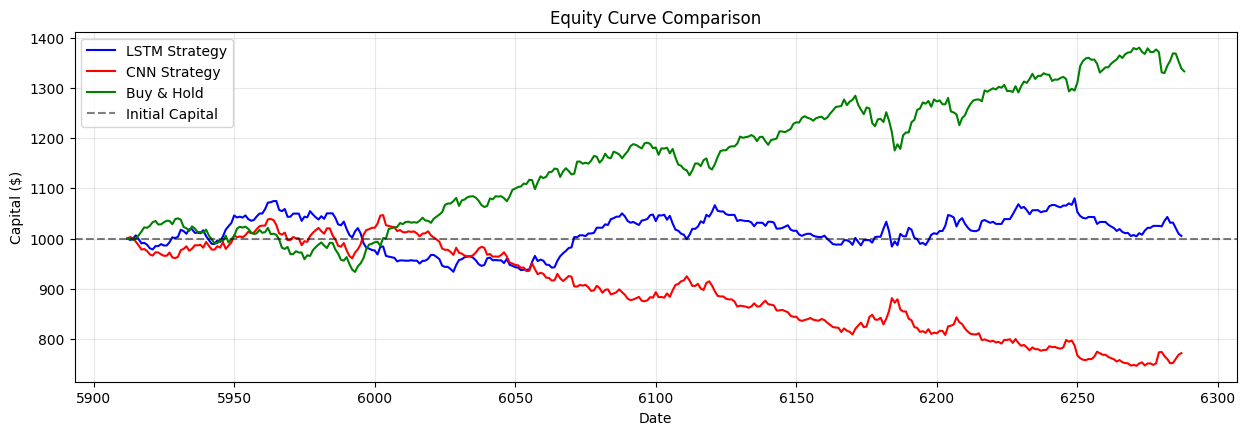

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


plt.figure(figsize=(15, 10)) # This will be created by plt.subplots

# Equity curve
plt.subplot(2, 1, 1) # This will be ax_equity

plt.plot(lstm_results['dates'], lstm_results['daily_capital'], label='LSTM Strategy', color='blue')
plt.plot(cnn_results['dates'], cnn_results['daily_capital'], label='CNN Strategy', color='red')
plt.plot(buy_hold_results['dates'], buy_hold_results['daily_capital'], label='Buy & Hold', color='green')
plt.axhline(y=1000, color='black', linestyle='--', alpha=0.5, label='Initial Capital')
plt.title('Equity Curve Comparison')
plt.xlabel('Date')
plt.ylabel('Capital ($)')
plt.legend()
plt.grid(True, alpha=0.3)


C:\Users\Cameron\AppData\Local\Temp\ipykernel_19664\501833562.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = df_returns.resample('M').last().pct_change().dropna()
C:\Users\Cameron\AppData\Local\Temp\ipykernel_19664\501833562.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = df_returns.resample('M').last().pct_change().dropna()
C:\Users\Cameron\AppData\Local\Temp\ipykernel_19664\501833562.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = df_returns.resample('M').last().pct_change().dropna()


No monthly return data available to plot for any strategy. The simulation period might be too short.

===== TRADE STATISTICS =====

LSTM Model:
Total Trades: 375
Long Positions: 131 (34.9%)
Short Positions: 94 (25.1%)
Successful Trades: 111 (29.6%)

CNN Model:
Total Trades: 375
Long Positions: 43 (11.5%)
Short Positions: 311 (82.9%)
Successful Trades: 154 (41.1%)


<Figure size 1500x800 with 0 Axes>

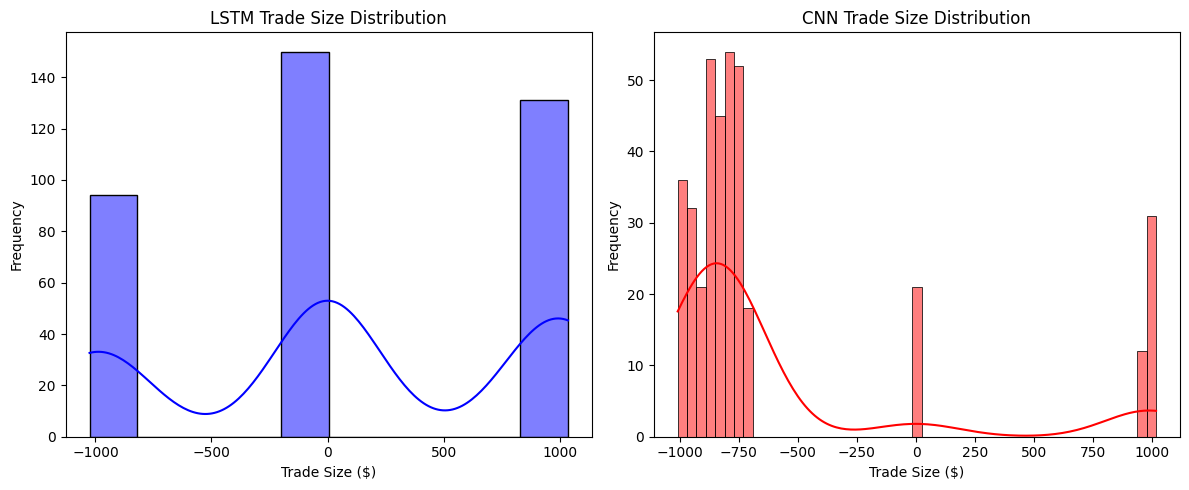

In [100]:

# Analyze trading positions and signals

# Calculate monthly returns
# Analyze trading positions and signals

# Calculate monthly returns
def calculate_monthly_returns(dates, daily_capital):
    # Convert to DataFrame for easier resampling
    # Ensure the index is a DatetimeIndex
    idx = pd.to_datetime(dates)
    df_returns = pd.DataFrame({'capital': daily_capital}, index=idx)
    monthly_returns = df_returns.resample('M').last().pct_change().dropna()
    return monthly_returns

# ...existing code...
lstm_monthly_returns = calculate_monthly_returns(lstm_results['dates'], lstm_results['daily_capital'])
cnn_monthly_returns = calculate_monthly_returns(cnn_results['dates'], cnn_results['daily_capital']) 
bh_monthly_returns = calculate_monthly_returns(buy_hold_results['dates'], buy_hold_results['daily_capital'])

# Plot monthly returns
plt.figure(figsize=(15, 8))
bar_width = 0.25

# Consolidate monthly returns for robust plotting
all_strategies_returns = {
    "LSTM": lstm_monthly_returns,
    "CNN": cnn_monthly_returns,
    "Buy & Hold": bh_monthly_returns
}

plot_data_frames = []
for strategy_name, monthly_df in all_strategies_returns.items():
    if not monthly_df.empty and 'capital' in monthly_df.columns:
        plot_data_frames.append(monthly_df[['capital']].rename(columns={'capital': strategy_name}))

if not plot_data_frames:
    print("No monthly return data available to plot for any strategy. The simulation period might be too short.")
else:
    # Concatenate all available monthly returns. They should have DatetimeIndex.
    # axis=1 aligns by index (Month). join='outer' keeps all months from all strategies.
    combined_returns_df = pd.concat(plot_data_frames, axis=1, join='outer')
    
    # For bar plot, fillna(0) is often reasonable if a strategy had no return for a month where others did.
    combined_returns_df = combined_returns_df.fillna(0.0)

    if combined_returns_df.empty:
        print("Combined monthly return data is empty after processing. Nothing to plot.")
    else:
        num_months = len(combined_returns_df)
        x_positions = np.arange(num_months) # Numeric positions for bars

        ax = plt.gca() # Get current axes for plotting

        if "LSTM" in combined_returns_df.columns:
            ax.bar(x_positions - bar_width, combined_returns_df["LSTM"], bar_width, label='LSTM', color='blue', alpha=0.7)
        if "CNN" in combined_returns_df.columns:
            ax.bar(x_positions, combined_returns_df["CNN"], bar_width, label='CNN', color='red', alpha=0.7)
        if "Buy & Hold" in combined_returns_df.columns:
            ax.bar(x_positions + bar_width, combined_returns_df["Buy & Hold"], bar_width, label='Buy & Hold', color='green', alpha=0.7)

        plt.title('Monthly Returns Comparison')
        plt.xlabel('Month')
        plt.ylabel('Return (%)')
        
        # Set xticks based on the combined DataFrame's index
        plt.xticks(x_positions, combined_returns_df.index.strftime('%Y-%m'), rotation=45, ha="right")
        
        plt.legend()
        plt.grid(True, axis='y', alpha=0.3) # Grid on y-axis is common for bar charts
        plt.tight_layout()
        plt.show()



# Display trade statistics for LSTM
lstm_positions = pd.DataFrame(lstm_results['positions'])
cnn_positions = pd.DataFrame(cnn_results['positions'])

# Calculate success rate
def calculate_trade_stats(positions, df):
    positions['next_price'] = positions['date'].apply(lambda date: df.loc[df.index > date, TARGET_COL].iloc[0] if date < df.index[-1] else None)
    positions['success'] = positions.apply(lambda row: 
        ((row['type'] == 'LONG' and row['next_price'] > row['price']) or 
         (row['type'] == 'SHORT' and row['next_price'] < row['price'])) if row['next_price'] is not None else None, axis=1)
    
    stats = {
        'total_trades': len(positions),
        'long_trades': len(positions[positions['type'] == 'LONG']),
        'short_trades': len(positions[positions['type'] == 'SHORT']),
        'successful_trades': positions['success'].sum(),
        'success_rate': positions['success'].mean() * 100
    }
    return stats, positions

lstm_stats, lstm_positions_updated = calculate_trade_stats(lstm_positions, df)
cnn_stats, cnn_positions_updated = calculate_trade_stats(cnn_positions, df)

# Display trade stats
print("\n===== TRADE STATISTICS =====")
print("\nLSTM Model:")
print(f"Total Trades: {lstm_stats['total_trades']}")
print(f"Long Positions: {lstm_stats['long_trades']} ({lstm_stats['long_trades']/lstm_stats['total_trades']*100:.1f}%)")
print(f"Short Positions: {lstm_stats['short_trades']} ({lstm_stats['short_trades']/lstm_stats['total_trades']*100:.1f}%)")
print(f"Successful Trades: {lstm_stats['successful_trades']} ({lstm_stats['success_rate']:.1f}%)")

print("\nCNN Model:")
print(f"Total Trades: {cnn_stats['total_trades']}")
print(f"Long Positions: {cnn_stats['long_trades']} ({cnn_stats['long_trades']/cnn_stats['total_trades']*100:.1f}%)")
print(f"Short Positions: {cnn_stats['short_trades']} ({cnn_stats['short_trades']/cnn_stats['total_trades']*100:.1f}%)")
print(f"Successful Trades: {cnn_stats['successful_trades']} ({cnn_stats['success_rate']:.1f}%)")

# Trade size distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(lstm_positions['size'], kde=True, color='blue')
plt.title('LSTM Trade Size Distribution')
plt.xlabel('Trade Size ($)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(cnn_positions['size'], kde=True, color='red')
plt.title('CNN Trade Size Distribution')
plt.xlabel('Trade Size ($)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



===== RISK-ADJUSTED PERFORMANCE COMPARISON =====



,LSTM Strategy,CNN Strategy,Buy & Hold
Annual Return,2.51%,-19.17%,20.38%
Annual Volatility,9.31%,12.09%,12.30%
Sharpe Ratio,0.27,-1.59,1.66
Sortino Ratio,0.30,-2.52,2.28
Calmar Ratio,0.34,-0.58,1.99
Win Rate,29.60%,41.07%,56.80%
Avg. Gain,0.59%,0.59%,0.59%
Avg. Loss,-0.54%,-0.60%,-0.59%
Profit Factor,1.06,0.76,1.32


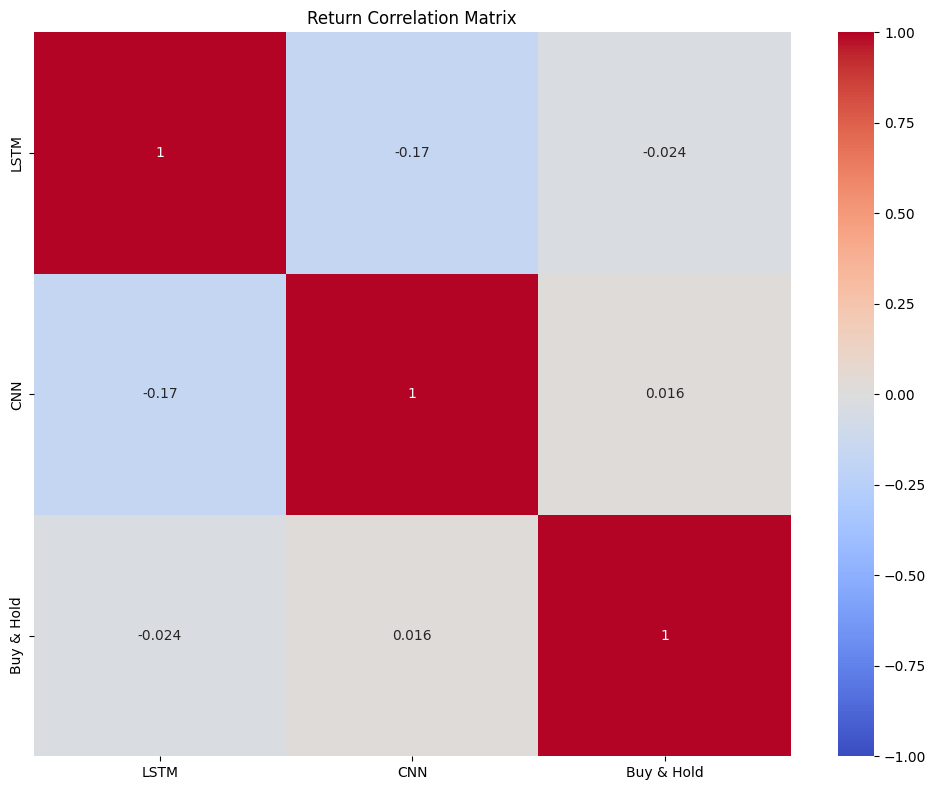

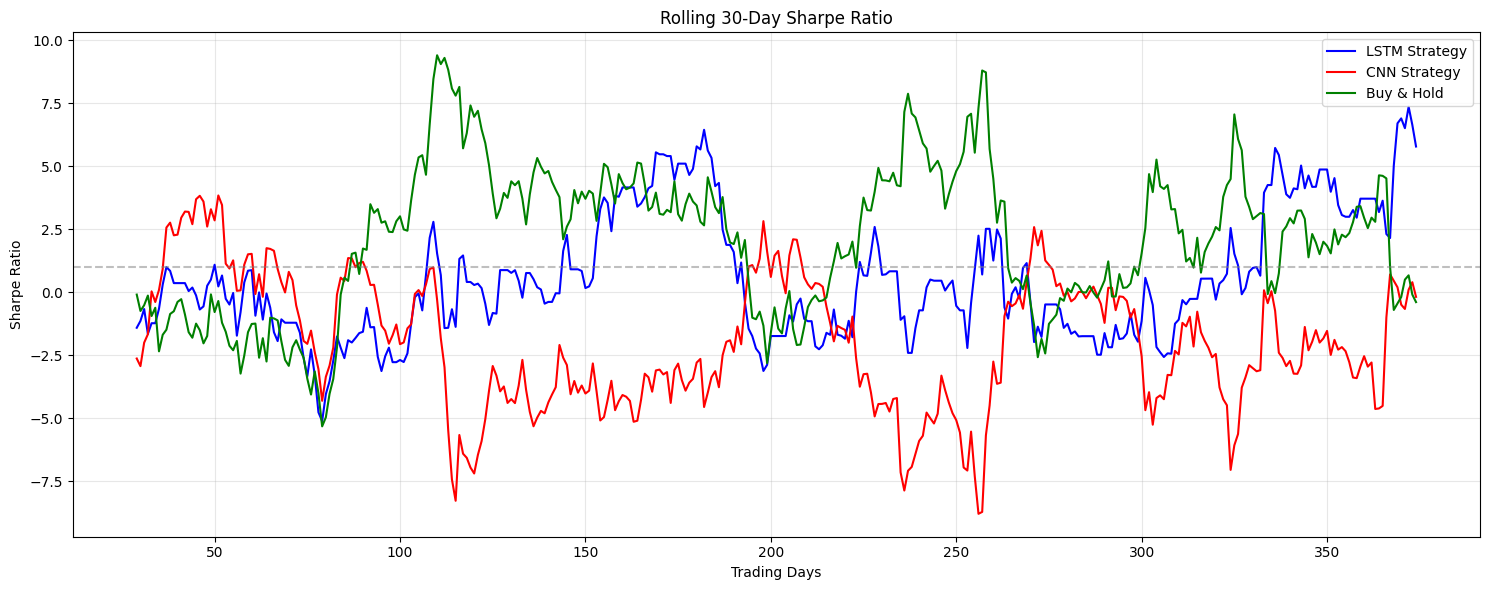

In [101]:

# Calculate additional risk metrics
def calculate_risk_metrics(returns):
    """Calculate advanced risk-adjusted performance metrics"""
    # Convert returns to numpy array
    returns_array = np.array(returns)
    
    # Annual return (assuming 252 trading days)
    annual_return = np.mean(returns_array) * 252
    
    # Annual volatility
    annual_vol = np.std(returns_array) * np.sqrt(252)
    
    # Sharpe ratio (already calculated but included for completeness)
    sharpe = annual_return / annual_vol if annual_vol != 0 else 0
    
    # Sortino ratio (downside risk only)
    downside_returns = returns_array[returns_array < 0]
    downside_deviation = np.std(downside_returns) * np.sqrt(252) if len(downside_returns) > 0 else 0.001
    sortino = annual_return / downside_deviation if downside_deviation != 0 else 0
    
    # Calmar ratio (return / max drawdown)
    peak = np.maximum.accumulate(np.insert(returns_array, 0, 0).cumsum() + 1)
    drawdown = (peak - (np.insert(returns_array, 0, 0).cumsum() + 1)) / peak
    max_drawdown = np.max(drawdown)
    calmar = annual_return / max_drawdown if max_drawdown != 0 else 0
    
    # Win rate
    wins = np.sum(returns_array > 0)
    win_rate = wins / len(returns_array) if len(returns_array) > 0 else 0
    
    # Average gain and loss
    avg_gain = np.mean(returns_array[returns_array > 0]) if len(returns_array[returns_array > 0]) > 0 else 0
    avg_loss = np.mean(returns_array[returns_array < 0]) if len(returns_array[returns_array < 0]) > 0 else 0
    
    # Profit factor
    profit_factor = (np.sum(returns_array[returns_array > 0]) / -np.sum(returns_array[returns_array < 0])) if np.sum(returns_array[returns_array < 0]) != 0 else float('inf')
    
    return {
        'annual_return': annual_return,
        'annual_volatility': annual_vol,
        'sharpe_ratio': sharpe,
        'sortino_ratio': sortino,
        'calmar_ratio': calmar,
        'win_rate': win_rate,
        'avg_gain': avg_gain,
        'avg_loss': avg_loss,
        'profit_factor': profit_factor
    }

# Align lengths of daily_capital and dates from buy_hold_results
# to match lstm_results (and cnn_results, which should be same as lstm)
# This ensures that the subsequent return calculations are based on series of the same length.
if 'daily_capital' in lstm_results and 'daily_capital' in buy_hold_results:
    len_model_capital = len(lstm_results['daily_capital'])

    if len(buy_hold_results['daily_capital']) > len_model_capital:
        buy_hold_results['daily_capital'] = buy_hold_results['daily_capital'][:len_model_capital]
        # Also align 'dates' if it's used directly with daily_capital for plotting or indexing
        if 'dates' in buy_hold_results and len(buy_hold_results['dates']) > len_model_capital:
            buy_hold_results['dates'] = buy_hold_results['dates'][:len_model_capital]
elif 'daily_capital' in buy_hold_results and not 'daily_capital' in lstm_results:
    # Handle case where lstm_results might be empty but buy_hold_results is not
    # This scenario might indicate an issue upstream, but for robustness:
    if len(buy_hold_results['daily_capital']) > 0: # If B&H has data, and LSTM doesn't, we can't align to LSTM.
                                                 # This implies lstm_returns will be empty.
                                                 # To avoid error, bh_returns should also be empty or match.
                                                 # For now, let's assume if lstm_capital is 0, bh_capital should also be 0 for returns.
        buy_hold_results['daily_capital'] = []
        if 'dates' in buy_hold_results:
             buy_hold_results['dates'] = []


# Extract returns from daily capital
lstm_returns = []
if 'daily_capital' in lstm_results and len(lstm_results['daily_capital']) > 1:
    lstm_returns = [(lstm_results['daily_capital'][i] / lstm_results['daily_capital'][i-1]) - 1 for i in range(1, len(lstm_results['daily_capital']))]

cnn_returns = []
if 'daily_capital' in cnn_results and len(cnn_results['daily_capital']) > 1:
    cnn_returns = [(cnn_results['daily_capital'][i] / cnn_results['daily_capital'][i-1]) - 1 for i in range(1, len(cnn_results['daily_capital']))]

bh_returns = []
if 'daily_capital' in buy_hold_results and len(buy_hold_results['daily_capital']) > 1:
    bh_returns = [(buy_hold_results['daily_capital'][i] / buy_hold_results['daily_capital'][i-1]) - 1 for i in range(1, len(buy_hold_results['daily_capital']))]

# Calculate risk metrics
lstm_risk_metrics = calculate_risk_metrics(lstm_returns)
cnn_risk_metrics = calculate_risk_metrics(cnn_returns)
bh_risk_metrics = calculate_risk_metrics(bh_returns)

# Create a DataFrame to compare metrics
metrics_df = pd.DataFrame({
    'LSTM Strategy': [
        f"{lstm_risk_metrics['annual_return']*100:.2f}%",
        f"{lstm_risk_metrics['annual_volatility']*100:.2f}%",
        f"{lstm_risk_metrics['sharpe_ratio']:.2f}",
        f"{lstm_risk_metrics['sortino_ratio']:.2f}",
        f"{lstm_risk_metrics['calmar_ratio']:.2f}",
        f"{lstm_risk_metrics['win_rate']*100:.2f}%",
        f"{lstm_risk_metrics['avg_gain']*100:.2f}%",
        f"{lstm_risk_metrics['avg_loss']*100:.2f}%",
        f"{lstm_risk_metrics['profit_factor']:.2f}"
    ],
    'CNN Strategy': [
        f"{cnn_risk_metrics['annual_return']*100:.2f}%",
        f"{cnn_risk_metrics['annual_volatility']*100:.2f}%",
        f"{cnn_risk_metrics['sharpe_ratio']:.2f}",
        f"{cnn_risk_metrics['sortino_ratio']:.2f}",
        f"{cnn_risk_metrics['calmar_ratio']:.2f}",
        f"{cnn_risk_metrics['win_rate']*100:.2f}%",
        f"{cnn_risk_metrics['avg_gain']*100:.2f}%",
        f"{cnn_risk_metrics['avg_loss']*100:.2f}%",
        f"{cnn_risk_metrics['profit_factor']:.2f}"
    ],
    'Buy & Hold': [
        f"{bh_risk_metrics['annual_return']*100:.2f}%",
        f"{bh_risk_metrics['annual_volatility']*100:.2f}%",
        f"{bh_risk_metrics['sharpe_ratio']:.2f}",
        f"{bh_risk_metrics['sortino_ratio']:.2f}",
        f"{bh_risk_metrics['calmar_ratio']:.2f}",
        f"{bh_risk_metrics['win_rate']*100:.2f}%",
        f"{bh_risk_metrics['avg_gain']*100:.2f}%",
        f"{bh_risk_metrics['avg_loss']*100:.2f}%",
        f"{bh_risk_metrics['profit_factor']:.2f}"
    ]
}, index=[
    'Annual Return',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio',
    'Calmar Ratio',
    'Win Rate',
    'Avg. Gain',
    'Avg. Loss',
    'Profit Factor'
])

# Display comparison table
print("\n===== RISK-ADJUSTED PERFORMANCE COMPARISON =====\n")
display(metrics_df)

# Return correlation
plt.figure(figsize=(10, 8))
returns_df = pd.DataFrame({
    'LSTM': lstm_returns,
    'CNN': cnn_returns,
    'Buy & Hold': bh_returns
})
corr_matrix = returns_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Return Correlation Matrix')
plt.tight_layout()
plt.show()

# Plot rolling Sharpe ratio (30-day window)
window = 30
returns_df['LSTM_rolling_sharpe'] = (returns_df['LSTM'].rolling(window).mean() / 
                                   returns_df['LSTM'].rolling(window).std()) * np.sqrt(252)
returns_df['CNN_rolling_sharpe'] = (returns_df['CNN'].rolling(window).mean() / 
                                  returns_df['CNN'].rolling(window).std()) * np.sqrt(252)
returns_df['BH_rolling_sharpe'] = (returns_df['Buy & Hold'].rolling(window).mean() / 
                                 returns_df['Buy & Hold'].rolling(window).std()) * np.sqrt(252)

plt.figure(figsize=(15, 6))
plt.plot(returns_df['LSTM_rolling_sharpe'], label='LSTM Strategy', color='blue')
plt.plot(returns_df['CNN_rolling_sharpe'], label='CNN Strategy', color='red')
plt.plot(returns_df['BH_rolling_sharpe'], label='Buy & Hold', color='green')
plt.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
plt.title(f'Rolling {window}-Day Sharpe Ratio')
plt.xlabel('Trading Days')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
